# Reinforcement Learning

We'll need a game and a neural network before we get in to reinforcements. Both should be generalized. Tic Tac Toe should work just as well as Checkers, for example, as long as they meet the requirements.

## The Game
The game will require the following methods:
-  `valid_moves` - takes two arguments: the state of the game and the player; returns a list of valid moves for the player
-  `make_move` - takes two arguments: the move and the player; updates the state of the game if the move is valid
-  `get_game_state` - returns a deep copy of the game state
-  `victory_condition` - takes one argument: a player; returns True if the player has achieved a victory condition, otherwise False
-  `defeat_condition` - takes one argument: a player; returns True if the player has been defeated, otherwise False
-  `draw_condition` - returns True if the game is a draw, otherwise False
-  `game_is_over` - returns True if the game is over, otherwise False
-  `reset_game` - starts a fresh game
-  `get_next_player` - returns the value of the next player
-  `print_board` - prints the current board to the console output

And the following variables:
-  `players` - a list of the players

These must be true for any game we wish to teach a neural network to play with this setup. There could be six players, as in Chinese Checkers. There could be two players, as in Chess. There could be one player that plays against a board, as in Arkham Horror (or the Stock Market).

## Neural Network
The Neural Network will require the following methods:
-  `__init__(n_inputs, [n_hiddens_per_layer], n_outputs)` - `n_inputs` is the number of inputs to the neural network, `[n_hiddens_per_layer]` is a list of the size of each hidden layer, `n_outputs` is the number of output values for the network
-  `use(X)` - takes one argument: the state and action pair; returns a rating between -1 and 1
-  `train(X, T, epochs, learning_rate)` - takes four arguments: the state/action pair as an array, the target, the number of epochs, and the learning rate; updates internal weights

We must be able to initialize the network with a number of inputs, hidden layers, outputs, and toggle standardizing the inputs off (somehow).

# Reinforcements

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas
import neuralnetworks as nn
import tictactoe as playing

Initialize the game and values for win/loss/draw analytics.

In [2]:
the_game = playing.Game()
win_value = 1
lose_value = -1
draw_value = 0
positive_reinforcement = 1
negative_reinforcement = -1
neutral_reinforcement = 0

In [3]:
def player_outcome(game, player):
    if game.victory_condition(player):
        return win_value
    elif game.defeat_condition(player):
        return lose_value
    elif game.draw_condition():
        return draw_value
    return None

Set reinforcement functions. "r" for reward, "p" for punish. These will be generalized, so they all take the same argmuments.
-  `r_win_p_lose_draw`: positive reinforcement for wins, negative reinforcement for losses and draws
-  `r_win_draw_p_lose`: positive reinforcement for wins and draws, negative reinforcement for losses 
-  `r_win_p_lose`: positive reinforcement for wins, negative reinforcement for losses, ignores draws
-  `r_lose_p_win_draw`: positive reinforcement for losses, negative reinforcement for wins and draws
-  `r_lose_draw_p_win`: positive reinforcement for losses and draws, negative reinforcement for wins
-  `r_lose_p_win`: positive reinforcement for losses, negative reinforcement for wins, ignores draws
-  `r_draw_p_win`: positive reinforcement for draws, negative reinforcement for wins, ignores losses
-  `r_draw_p_lose`: positive reinforcement for draws, negative reinforcement for losses, ignores wins
-  `r_draw_p_win_lose`: positive reinforcement for draws, negative reinforcement for wins and losses

In [4]:
def r_win_p_lose_draw(game, player):
    if game.victory_condition(player):
        return positive_reinforcement
    if game.draw_condition() or game.defeat_condition(player):
        return negative_reinforcement
    return neutral_reinforcement

def r_win_draw_p_lose(game, player):
    if game.victory_condition(player) or game.draw_condition():
        return positive_reinforcement
    if game.defeat_condition(player):
        return negative_reinforcement
    return neutral_reinforcement

def r_win_p_lose(game, player):
    if game.victory_condition(player):
        return positive_reinforcement
    if game.defeat_condition(player):
        return negative_reinforcement
    return neutral_reinforcement

def r_lose_p_win_draw(game, player):
    return -1 * r_win_draw_p_lose(game, player)

def r_lose_draw_p_win(game, player):
    return -1 * r_win_p_lose_draw(game, player)

def r_lose_p_draw(game, player):
    return -1 * r_win_p_lose(game, player)

def r_draw_p_win(game, player):
    if game.draw_condition():
        return positive_reinforcement
    if game.victory_condition(player):
        return negative_reinforcement
    return neutral_reinforcement

def r_draw_p_lose(game, player):
    if game.draw_condition():
        return positive_reinforcement
    if game.defeat_condition(player):
        return negative_reinforcement
    return neutral_reinforcement

def r_draw_p_win_lose(game, player):
    if game.draw_condition():
        return positive_reinforcement
    if  game.victory_condition(player) or game.defeat_condition(player):
        return negative_reinforcement
    return neutral_reinforcement

reinforcement_fs_list = [r_win_p_lose, r_win_draw_p_lose, r_win_p_lose_draw, 
                        r_lose_p_draw, r_lose_draw_p_win, r_lose_p_win_draw, 
                        r_draw_p_win, r_draw_p_lose, r_draw_p_win_lose]

In [5]:
def stack_sa(s, a):
    return np.hstack((s, a)).reshape(1, -1)

In [6]:
def uniform_explore(net=None, state=None, valid_moves=[], epsilon=None):
    return np.random.choice(valid_moves)

In [7]:
def greedy(net, state, valid_moves, epsilon=None):
    np.random.shuffle(valid_moves)
    move_ratings = np.array([net.use(stack_sa(state, a)) for a in valid_moves])
    return valid_moves[np.argmax(move_ratings)]

In [8]:
def epsilon_greedy(net, state, valid_moves, epsilon):
    if np.random.uniform() < epsilon:
        # Random Move
        move = np.random.choice(valid_moves)
    else:
        # Greedy Move
        move = greedy(net, state, valid_moves)
    return move

In [9]:
def greedy_game(Qnets, game):
    game.reset_game()
    rng = np.random.default_rng()
    current_player = rng.choice(game.players)[0]
    while not game.game_is_over():
        original_state = game.get_game_state()
        move = greedy(Qnets[current_player], original_state, game.valid_moves(original_state, current_player))
        game.make_move(move, current_player)
        current_player = game.get_next_player()
    outcome = {}
    for player in game.players:
        outcome[player] = player_outcome(game, player)
    return game, outcome

In [10]:
def replace_player(state, old_value, new_value):
    state[state == old_value] = new_value
    return state

In [11]:
def cycle_board(game, state):
    state = -state
    for i in range(len(game.players[:-1])):
        old_player = game.players[i]
        new_player = game.players[i+1]
        state = replace_player(state, -game.player_values[old_player], game.player_values[new_player])
    state = replace_player(state, -game.player_values[game.players[-1]], game.player_values[game.players[0]])
    return state


In [12]:
def make_samples(Qnets, game, reinforcement_fs, epsilon, choice_fs, first_player=None):
    '''Get samples from running one game'''
    # Generate samples for all players
    Samples = {}
    for player in game.players:
        Samples[player] = {'State_Action': [], 'Reinforcement': [], 'Move_Rating': []}

    # Sets up the game
    game.reset_game()
    
    # Sets first player
    if first_player == None:
        # Randomly selects first player
        rng = np.random.default_rng()
        current_player = rng.choice(game.players)[0]
    else:
        current_player = first_player

    # Plays one game, updating samples with each move
    while not game.game_is_over():
        # Stores the pre-move state
        original_state = game.get_game_state()
        # Figures out the move the current player will take
        move = choice_fs[current_player](Qnets[current_player], original_state, game.valid_moves(original_state, current_player), epsilon)
        # Makes the move, thus changing the state of the game
        game.make_move(move, current_player)
        # Gets the reinforcement value for the move
        reinforcement_value = reinforcement_fs[current_player](game, current_player)
        # Stores the move information in the sample for the current player
        Samples[current_player]['State_Action'].append(stack_sa(original_state, move))
        Samples[current_player]['Reinforcement'].append(reinforcement_value)   # r is with respect to player
        Samples[current_player]['Move_Rating'].append(0.0)  # fill in layer
        # Sets the current player to the next player
        current_player = game.get_next_player()
    
    # Update samples for each player
    for player in game.players:
        Samps = Samples[player]
        # Update reinforcement
        Samps['Reinforcement'][-1] = reinforcement_fs[player](game, player)
        # Update game outcome
        Samps['Outcome'] = player_outcome(game, player)
        # Reshape samples
        Samps['State_Action'] = np.vstack(Samps['State_Action'])
        Samps['Reinforcement'] = np.array(Samps['Reinforcement']).reshape(-1, 1)
        Samps['Move_Rating'] =  np.array(Samps['Move_Rating']).reshape(-1 ,1)
        # Use neural net to update final "move" rating
        Samps['Move_Rating'][:-1] = Qnets[player].use(Samps['State_Action'][1:])
        # Reshape results
        Samps['Move_Rating'] = np.array(Samps['Move_Rating']).reshape(-1, 1)

    return Samples

In [13]:
def plot_player(columns, column, outcome_rows, xs, avgs, n_per, epsilon_graph, player):
    plt.subplot(3, columns, column + 1)
    plt.plot(xs, avgs)
    plt.ylim(-1.1, 1.1)
    plt.xlabel('Games')
    plt.ylabel('Mean of Outcomes') # \n(0=draw, 1=win, -1=lose)')
    plt.title(f'Bins of {n_per:d} Games')
    
    plt.subplot(3, columns, column + columns + 1)
    plt.plot(xs, np.sum(outcome_rows == -1, axis=1), 'r-', label=f'{player} Losses')
    plt.plot(xs, np.sum(outcome_rows == 0, axis=1), 'b-', label='Draws')
    plt.plot(xs, np.sum(outcome_rows == 1, axis=1), 'g-', label=f'{player} Wins')
    plt.legend(loc='center')
    plt.ylabel(f'Number of Games\nin Bins of {n_per:d}')
    
    plt.subplot(3, columns, column + (columns * 2) + 1)
    plt.plot(epsilon_graph)
    plt.ylabel('$\epsilon$')

In [14]:
def plot_status(all_outcomes, epsilons, trial, game):
    if trial == 0:
        return
    n_per = 10
    n_bins = (trial + 1) // n_per
    if n_bins == 0:
        return
    columns = len(game.players)
    for i in range(columns):
        outcomes = np.array(all_outcomes[game.players[i]])
        outcome_rows = outcomes[:n_per * n_bins].reshape((-1, n_per))
        outcome_rows = outcome_rows[:trial // n_per + 1, :]
        avgs = np.mean(outcome_rows, axis=1)
        xs = np.linspace(n_per, n_per * n_bins, len(avgs))
        plot_player(columns, i, outcome_rows, xs, avgs, n_per, epsilons[:trial], game.players[i])


In [15]:
def setup_neural_networks(game):
    # Set number of inputs to the size of the gameboard plus one for the move
    n_inputs = len(game.gameboard) + 1
    # Set the size of the hidden layers
    n_hidden_nodes = n_inputs * 2
    # Set the depth of the hidden layers
    depth = int(np.ceil(np.sqrt(n_inputs - 1)))
    # Set the hidden layer topology
    hiddens = []
    for _ in range(depth):
        hiddens.append(n_hidden_nodes)
    Qnets = {}
    for player in game.players:
        Qnets[player] = nn.NeuralNetwork(n_inputs, hiddens, 1)
    # Set standardization to zeroes
    zero_input = np.array([0] * n_inputs).reshape(1,-1)
    zero_output = np.array([0]).reshape(1,-1)
    for player in game.players:
        Qnets[player].train(zero_input, zero_output, 1, 0, verbose=False)
    return Qnets
    

In [16]:
def set_choice_function(outcome):
    if outcome == win_value:
        return uniform_explore
    elif outcome == draw_value:
        return epsilon_greedy
    else:
        return greedy

In [17]:
from IPython.display import display, clear_output

def learn_game(game, reinforcement_fs, Qnets=None, n_games_to_play=100, n_epochs=200, learning_rate=0.1, choice_fs=None, graphics=False):
    if graphics:
        fig = plt.figure(figsize=(10*len(game.players), 10))

    if Qnets == None:
        Qnets = setup_neural_networks(game)
    gamma = 1.0        # discount factor
    final_epsilon = 0.01 # value of epsilon at end of simulation. Decay rate is calculated
    epsilon_decay = np.exp(np.log(final_epsilon) / (n_games_to_play)) # to produce this final value

    epsilon = 1
    epsilon_trace = []
    outcomes = {}
    for player in game.players:
        outcomes[player] = []

    # Sets choice function
    if choice_fs == None:
        choice_fs = {}
        for player in game.players:
            choice_fs[player] = epsilon_greedy

    # Train for n_trials
    for play in range(n_games_to_play):

        # Make sample data
        Samples = make_samples(Qnets, game, reinforcement_fs, epsilon, choice_fs)

        for player in game.players:
            Samps = Samples[player]
            outcomes[player].append(Samps['Outcome'])
            SA = Samps['State_Action']
            R = Samps['Reinforcement']
            Qn = Samps['Move_Rating']
            T = R + gamma * Qn
            Qnets[player].train(SA, T, n_epochs, learning_rate, verbose=False)
        
        epsilon_trace.append(epsilon)

        epsilon *= epsilon_decay
        
        if graphics and (play + 1 == n_games_to_play or play % (n_games_to_play / 20) == 0):
            plt.clf()
            plot_status(outcomes, epsilon_trace, play, game)
            clear_output(wait=True)
            display(fig)

    if graphics:
        clear_output(wait=True)
    return outcomes, Qnets

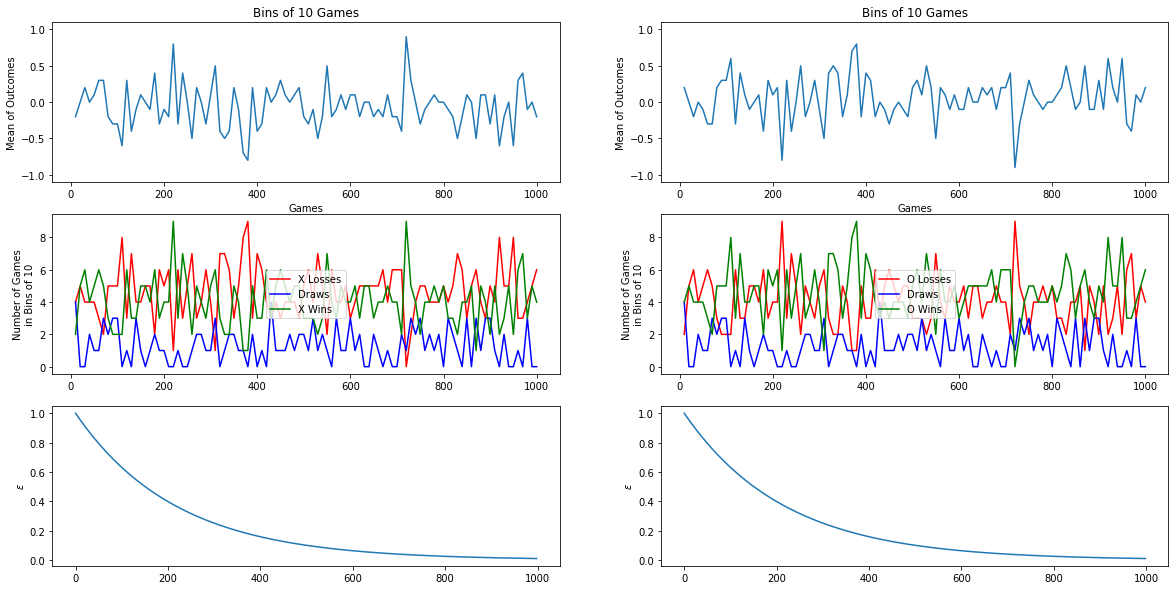

In [18]:
reinforcement_fs = {}
for player in the_game.players:
    reinforcement_fs[player] = r_win_draw_p_lose

result, Qnets = learn_game(the_game, reinforcement_fs, n_games_to_play=1000, graphics=True)

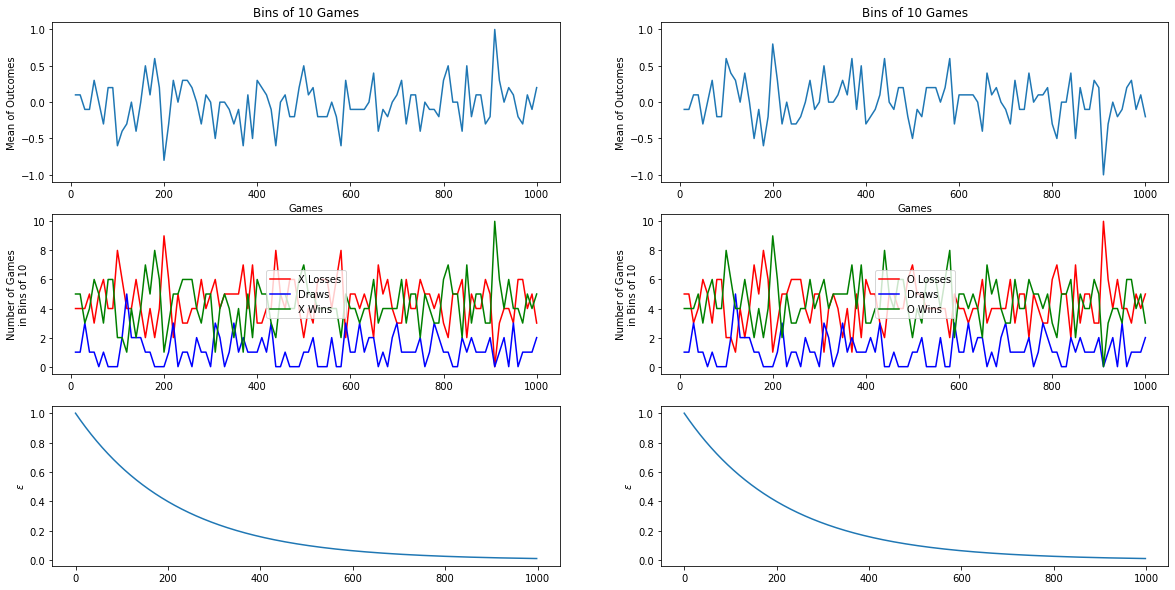

In [19]:
choice_fs = {the_game.players[1]: greedy, the_game.players[0]: greedy}
result, Qnets = learn_game(the_game, reinforcement_fs, Qnets=Qnets, n_games_to_play=1000, choice_fs=choice_fs, graphics=True)

In [20]:
Qnets

{'X': <neuralnetworks.NeuralNetwork at 0x234e4b5f310>,
 'O': <neuralnetworks.NeuralNetwork at 0x234ae8fcdc0>}

In [21]:
print(Qnets['X'])
print(Qnets['O'])

In [22]:
for player in the_game.players:
    print(f"{player}: {np.mean(result[player])}")

X: -0.021
O: 0.021


In [23]:
def print_move_ratings(Qnets, game, state, player):
    move_ratings = np.array([Qnets[player].use(stack_sa(state, a)) for a in game.valid_moves(state, player)])
    print(f"Move ratings for {player}")
    print(f"{move_ratings}")
    print()

In [24]:
state = np.array([0] * 9)

print_move_ratings(Qnets, the_game, state, the_game.players[0])
print_move_ratings(Qnets, the_game, state, the_game.players[1])


Move ratings for X
[]

Move ratings for O
[[[-0.38463053]]

 [[-0.38463053]]

 [[-0.38463053]]

 [[-0.38463053]]

 [[-0.38463053]]

 [[-0.38463053]]

 [[-0.38463053]]

 [[-0.38463053]]

 [[-0.38463053]]]



In [25]:
temp_game, outcomes = greedy_game(Qnets, the_game)
temp_game.print_board()


O| |X
—————
X|O|O
—————
X|X|O

